## Project 4 (Chapter 5)
### Physics/Biology 212, Spring 2020

Laird Stewart <br>
Date: 04/18/20

### Introduction
Diffusion-limited aggregation is a natural process where particles or molecules undergoing brownian motion stick together to form a cluster. Diffusion-limited aggregation or DLA occurs in many different cases including the creation of snowflakes, or zinc ions aggregating onto electrodes. This project will use python to model this phenomenon. 

### Problem Analysis
In order to model DLA there are two main components. First, simmulating browinan motion. And second having each particle 'stick' to a central point to form an expanding cluster. 

The first component will be accomplished by generating a random direction at discrrete time intervals (left, right, up, down) and moving the walker (brownian motion particle) in that direction. 

The second component is a bit trickier. Insead of just having a dot that can move in one of the four directions in an x,y plane, we will place each walker into a lattice represented by a matrix in code and each step will simply consist of updating the walker's position in the matrix. By running these random walks inside of a matrix this allows us to store boolean information within it (1 for a particle, 0 for empty space) this will help us to form and keep track of the cluster. 

There isn't much math to derive here, the one thing that should be said however, is that even though our random walk is discrete in time and distance over large time and spatial scales this is really no different than a discrete time or descrete space walk, or any combination of the two. 

### Model Development
As I said above, there really isn't much math or a model to develop here most of the work in this project comes from developing the actual code. We aren't modeling any sort of mathematical equation, instead we are creating a simmulation of random walks. 

### Code Analysis
My code is built upon the starter code and expands upon the following things: 
- change start walker function so it starts in a (slightly larger) circle around the cluster (done) 
- change run walker so the agent can't leave the circle instead of the entire lattice (done)
- monitor horizontal width of the cluster at each point in time (and plot it) (done)
- combine frames into a movie (8.2 in textbook) (done)


**First, I will explain how the starter code works in more depth:** <br>
The starter code contains three main sections: start walker, run walker, and the actual initialization of the lattice and loop running each walker in the lattice. Start walker simply chooses a random position along the edge of the lattice for the walker to begin at. Run walker loops through a series of random steps of the walker simmulating brownian motion. Run walker does not allow the walker to exit the lattice, this is called 'deflection'. It could have also been implemented so that if a walker left the lattice we delete it and try again. Finally, run walker terminates once the walker comes in contact with a neighboring cell in the matrix that is part of the cluster (we represent the cluster with booleans (1, 0's)). 

**Now, I will explain how I have modified the code to meet the above criteria:** <br>
The goal of my additions are to make the process run faster and allow us to run the process on much larger lattices. I accomplish this by releasing each walker randomly in a circle around the cluster. This immediately requires two parts: 
1. finding the radius of the cluster at any given time, 
2. get a random starting point on that circle for the walker to begin in.

To find the maximum radius of the cluster I wrote a helper function called 'get_radius'. This function loops through the lattice to find the part of the cluster furthest from the center. **note on runtime**. Once we have the radius of the cluster, I simply generate a random angle and start the walker at that angle (a bit further than the radius). If the walker starts directly on the radius, some randomness is lost, and in the beggining each walker will just accumulate on top of eachother. <br>
Next, we don't want the walker to leave that radius we started it at because that would defeat the whole purpose. To remedy this after generating each new step of the walker I check if that would cause it to leave the radius, if it would, I generate a new step. <br>
To monitor the horizontal width of the cluster I wrote a helper method very simmilar to 'get_radius', again this runs in $O(m^2)$ time wich is bad. <br> 
Finally to convert the simmulation into a movie I wrote a loop that saves the current state of the lattice as a .png file and then use an external library to stich those .png files into a move in html form. <br> 
Finally, the last thing that I added to my code was raising an error once the radius of the cluster got too large for the lattice to contain it. If I did not raise this error we could potentially be starting walkers outside of the lattice which would cause an out of bounds error. I thought about just starting the walkers on the wall of the lattice after this point, but that defeats the purpose of the symmetry of starting in a cirlce. 
<br>
<br>

**Runtime Note** <br>
If the size of the lattice is m, this (get_radius) runs in $O(m^2)$ time, which is not ideal, but should still be faster than a hugely long random walk if we have a large matrix. If I wanted to further increase the run-time of this algoritm I wouldn't search the entire lattice for the furthest out point in the cluster, but instead keep track of the previous radius and only search a bit further out from that. This would cause the algorithm at each step to run on $O(r^2)$ time where r is the previous radius of the cluster. To improve this even further, we could, perhaps, only search in an outer ring for the furthest agent, this would cut the run time drastically. 


### Model Implementaiton

In [34]:
# Importing Modules
import numpy as np
import numpy.random as nprnd
import matplotlib.pyplot as plt
from html_movie import movie  # special module 

%matplotlib inline 

In [20]:
def get_width(lattice):
    # loop through entire matrix and find min and max horizontal coordinate of the cluster
    L = lattice.shape[0]
    x_min = L  # make these opposites, so we can update them
    x_max = 0
    for i in range(0, L):
        for j in range(0, L):
            position = lattice[i][j]
            if position == 1 and j < x_min:  # update x_min
                x_min = j
            if position == 1 and j > x_max:  # update x_max
                x_max = j
    return x_max - x_min

In [21]:
def get_radius(lattice):
    # return radius of furthest out agent from the center
    L = lattice.shape[0]
    x = 0  # update these as we find further and further out points
    y = 0
    for i in range(0, L):
        for j in range(0, L):
            position = lattice[i][j]
            x_cord = j - L / 2  # get coordinates in terms of center
            y_cord = i - L / 2
            if position == 1 and np.sqrt(x_cord ** 2 + y_cord ** 2) > np.sqrt(x ** 2 + y ** 2):  # compare radii
                x = x_cord
                y = y_cord
    radius = np.sqrt(x ** 2 + y ** 2)
    if radius + 6 > L / 2:  # i add 5 to the radius in 'start_walker_circle' so this means i could go outside of it
        raise NameError("lattice is too small to contain the cluster")

    return radius

In [22]:
def start_walker_circle(lattice):
    # return x and y coordinates of where to start the next random walker based on the current lattice
    r = get_radius(lattice)
    r = r + 5  # make radius slightly bigger so it still has some randomness
    angle = nprnd.random() * 2 * np.pi
    x = int(np.sin(angle) * r)
    y = int(np.cos(angle) * r)
    return int(L / 2) + x, int(L / 2) + y

In [23]:
def run_walker_circle(lattice):
    L = lattice.shape[0]  # size of lattice
    r = get_radius(lattice)  # radius of lattice
    x, y = start_walker_circle(lattice)  # starting point of walker

    while True:  # run until the walker gets stuck
        while True:  # generate potential moves that don't run into the circle boundary
            # generate random step
            directions = int(np.floor(nprnd.random(1) * 4))
            dx = (directions == 0) - 1.0 * (directions == 1)
            dy = (directions == 2) - 1.0 * (directions == 3)

            # check that we would still within the radius
            potential_new_x = x + dx
            potential_new_y = y + dy
            potential_new_radius = np.sqrt((L / 2 - potential_new_x) ** 2 + (L / 2 - potential_new_y) ** 2)

            if potential_new_radius < r + 5:  # if we are inside, go to next step 
                break

        x = x + int(dx)  # move the walker
        y = y + int(dy)
        # check agent's new neigbors
        neighbors_cluster = lattice[x, y + 1] + lattice[x, y - 1] + lattice[x + 1, y] + lattice[x - 1, y]
        if neighbors_cluster > 0:  # if a neighbor is part of the cluster
            lattice[x, y] = 1  # add the walker to the cluster
            break
    return lattice

In [24]:
N_walkers = 1000  # how many walkers in a cluster
L = 120  # lattice size
lattice = np.zeros((L, L))  # the lattice itself
lattice[int(L/2), int(L/2)] = 1   # seeding the DLA cluster
width = np.zeros(N_walkers)  # array to keep track of width in
t = np.arange(0, N_walkers)

# release N_walkers walkers and build the DLA cluster on the lattice.
for i in np.arange(N_walkers):
    lattice = run_walker_circle(lattice)
    width[i] = get_width(lattice)
    if np.round(i / 100) == i / 100:  # note every 100th walker
        print('Attached walker No. ' + str(i))  # print the progress

Attached walker No. 0
Attached walker No. 100
Attached walker No. 200
Attached walker No. 300
Attached walker No. 400
Attached walker No. 500
Attached walker No. 600
Attached walker No. 700
Attached walker No. 800
Attached walker No. 900


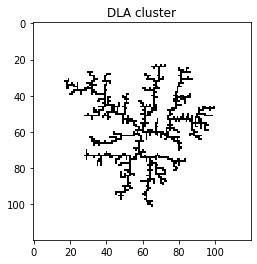

In [25]:
# plot the final cluster
plt.imshow(lattice, cmap='Greys', interpolation='nearest')
plt.title('DLA cluster')
plt.show()

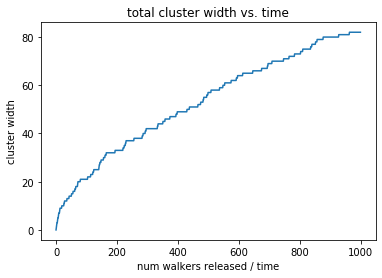

In [26]:
# Plot the width over time 
plt.plot(t, width)
plt.title("total cluster width vs. time")
plt.ylabel("cluster width")
plt.xlabel("num walkers released / time")
plt.show()

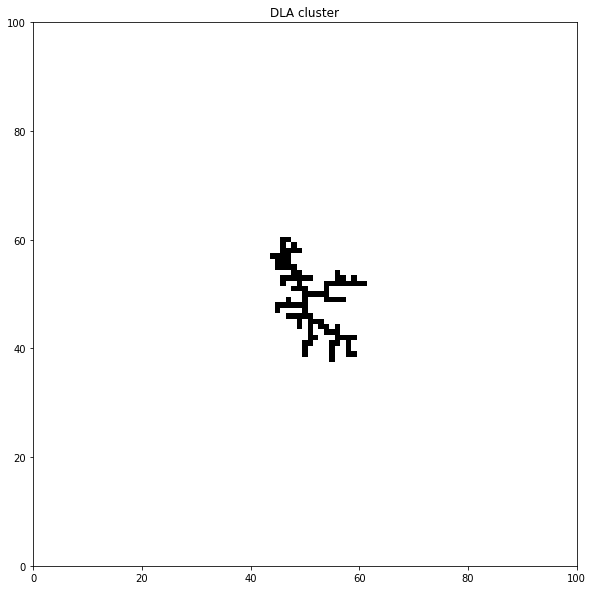

In [7]:
# Cluster Animation
N_walkers = 100  # THIS TAKES A LONG TIME, I WOULD SUGGEST A SMALLER NUMBER 
L = 100  # lattice size
lattice = np.zeros((L, L))  # the lattice itself
lattice[int(L/2), int(L/2)] = 1   # seeding the DLA cluster
width = np.zeros(N_walkers)  # array to keep track of width in
t = np.arange(0, N_walkers)

# initilization of the figure and file system 

plt.close('all')
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(0, L), ylim=(0, L))
file_name = "{:03d}_movie.png"

# for loop to save each step as a .png file

for i in range(N_walkers):  # num frames same as num walkers
    lattice = run_walker_circle(lattice)
    width[i] = get_width(lattice)
    plt.imshow(lattice, cmap='Greys', interpolation='nearest')
    plt.title('DLA cluster')
    plt.savefig(file_name.format(i))

In [8]:
# turns each .png into a movie in html, this only works with the html_movie module 
movie(input_files='*.png', output_file='movie.html')




Found 100 files of the format *.png.

Making HTML code for displaying 000_movie.png, 001_movie.png, 002_movie.png, 003_movie.png, 004_movie.png, 005_movie.png, 006_movie.png, 007_movie.png, 008_movie.png, 009_movie.png, 010_movie.png, 011_movie.png, 012_movie.png, 013_movie.png, 014_movie.png, 015_movie.png, 016_movie.png, 017_movie.png, 018_movie.png, 019_movie.png, 020_movie.png, 021_movie.png, 022_movie.png, 023_movie.png, 024_movie.png, 025_movie.png, 026_movie.png, 027_movie.png, 028_movie.png, 029_movie.png, 030_movie.png, 031_movie.png, 032_movie.png, 033_movie.png, 034_movie.png, 035_movie.png, 036_movie.png, 037_movie.png, 038_movie.png, 039_movie.png, 040_movie.png, 041_movie.png, 042_movie.png, 043_movie.png, 044_movie.png, 045_movie.png, 046_movie.png, 047_movie.png, 048_movie.png, 049_movie.png, 050_movie.png, 051_movie.png, 052_movie.png, 053_movie.png, 054_movie.png, 055_movie.png, 056_movie.png, 057_movie.png, 058_movie.png, 059_movie.png, 060_movie.png, 061_movie.pn

### Model Verification
There isn't much to do here in terms of verifying a model because I haven't really implemented a model just created a simmulation. However, I can still check that my simmulation is running correctly and doing what I want it to. I will check two things: 
1. Am I truely starting each walk in a circle? 
2. Are my walkers staying within the circle like they are supposed to?

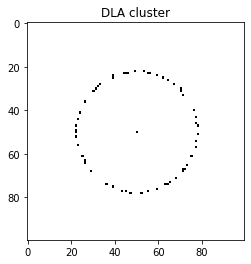

In [26]:
# #1. Is each new random walker truely staring in a circle.
# to do this I will create a 'cluster' by placing one dot some radius from the center
# then I will call start walker over and over again and plot where they start
# they should, in theory start in a circle a little bigger than that radius

L = 100  # lattice size
lattice1 = np.zeros((L, L))  # the lattice itself
lattice1[int(L/2), int(L/2)] = 1   # seeding the middle 
lattice1[30, 70] = 1 # seed another point 

# plot a bunch of test starting steps 
for i in range(0, 70): 
#     x, y = start_walker_circle(lattice1)
        # this actually breaks (as it should) because after we add each new dot, the
        # next one we add will be 5 further out from that one (that one was the new
        # max radius). So quickly it will be too big for the lattice. So i just copied
        # my code from 'start walker' minus the adding 5 part: 
    # return x and y coordinates of where to start the next random walker based on the current lattice
    r = get_radius(lattice)
    angle = nprnd.random() * 2 * np.pi
    x = int(np.sin(angle) * r)
    y = int(np.cos(angle) * r)
    x, y =  int(L / 2) + x, int(L / 2) + y
    lattice1[x][y] = 1

# plot 
plt.imshow(lattice1, cmap='Greys', interpolation='nearest')
plt.title('DLA cluster')
plt.show()

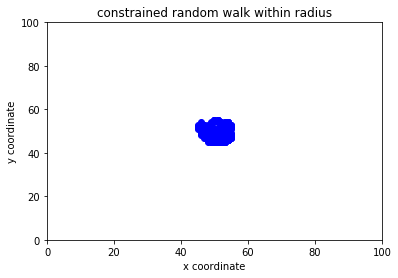

In [18]:
# #2. are my walkers staying within the circle? For this I will just plot the 
# trajectory of one walker I start within the circle to make sure it stays inside. 
# below is modified code from 'run_walker_circle' 

L = 100  # lattice size
lattice2 = np.zeros((L, L)) 
lattice2[int(L/2), int(L/2)] = 1 
lattice2[50, 51] = 1  # NEW --> walker will stay inside a radius of 6

length = 500 # NEW --> walk length 

x_coordinate = []  # new --> keep track of the walker so i can print it 
y_coordinate = []

L = lattice2.shape[0]
r = get_radius(lattice2)
x, y = start_walker_circle(lattice2)

for i in range (0, length): 
    while True:  
        directions = int(np.floor(nprnd.random(1) * 4))
        dx = (directions == 0) - 1.0 * (directions == 1)
        dy = (directions == 2) - 1.0 * (directions == 3)
        potential_new_x = x + dx
        potential_new_y = y + dy
        potential_new_radius = np.sqrt((L / 2 - potential_new_x) ** 2 + (L / 2 - potential_new_y) ** 2)
        if potential_new_radius < r + 5:  
            break
    x = x + int(dx)  
    y = y + int(dy)
    x_coordinate.append(x) # NEW --> keep track of walker 
    y_coordinate.append(y) # NEW 
    # NEW --> REMOVED THE STOPPING CONDITION, RUN A SET # TIMES 
        
plt.plot(x_coordinate, y_coordinate, 'b-o')
plt.title('constrained random walk within radius')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

### Discussion
How does the size grow with time? Is this a power law? If yes, which one? <br> 
The function of width over time ceartainly isn't linear, it appears to be a power law. For a power law equation $y = kx^a$ by looking at the graph I would guess a to be $\frac{1}{2}$ or $\frac{1}{4}$. I will fit it below: 

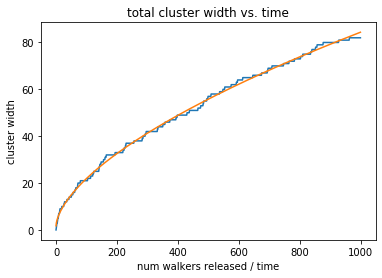

Fit equation in form: a + bx^c 
a = 1.7563926723045495
b = 1.2033978519174018
c = 0.6122942027655875


In [33]:
# run the first cell to get the width as a function of time 
# --> t 
# --> width
plt.plot(t, width)
plt.title("total cluster width vs. time")
plt.ylabel("cluster width")
plt.xlabel("num walkers released / time")

# Find a fit:
def power(x, a, b, c): 
    return a + b*x**c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(power, t, width, p0=[1, 1, 1/2])
a = popt[0]
b = popt[1]
c = popt[2]

plt.plot(t, power(t, a, b, c), label='power fit')
plt.show()

print("Fit equation in form: a + bx^c \na = "+str(a)+"\nb = "+str(b)+"\nc = "+str(c))

### Conclusion

In conclusion, it is clear that in order to maintain efficiency of a DLA simulation it is importatnt to keep in mind adding new walkers in a growing radius around the cluster instead of in a set square containing the cluster. The major inneficiency in doing this simmulation this way is that at each point we must scan the lattice to find the current radius of the cluster. In my implementation I scanned the entire lattice resulting in $O(n^2)$ time. This is clearly ineficient. It could be impoved by just searching in a ring around the previous radius as I described in the introduction. 

I have also shown that the width of the cluster over time grows with roughly the power law $x^{\frac{1}{2}}$. This makes sense because the cluster is a circle with area proportional to $r^2$, so as we add a steady stream of particles to the cluster the diameter will not grow linearly because more and more area is needed to grow in order to grow the diameter. 